In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


(array([111.,   0.,   0., 127.,   0.,   0.,  96.,   0.,   0., 109.]),
 array([769. , 769.3, 769.6, 769.9, 770.2, 770.5, 770.8, 771.1, 771.4,
        771.7, 772. ]),
 <a list of 10 Patch objects>)

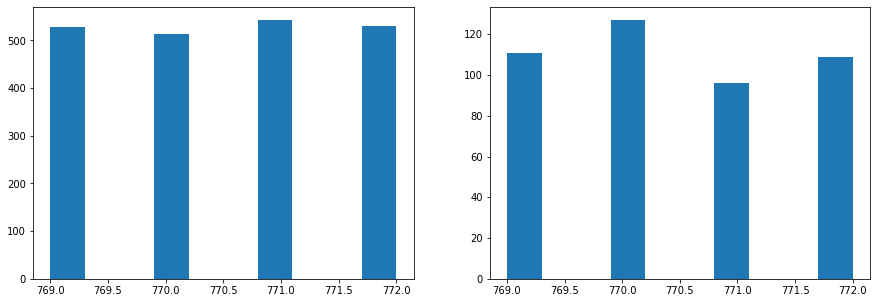

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train_valid)
plt.subplot(1, 2, 2)
plt.hist(y_test)

In [5]:
y_train_valid -= 769
y_test -= 769

In [6]:
import torch
import torch.nn as nn

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.LongTensor(Y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [8]:
from torch.utils.data import DataLoader

In [9]:
perm = np.random.permutation(X_train_valid.shape[0])
numTrain = int(0.8*X_train_valid.shape[0])
numVal = X_train_valid.shape[0] - numTrain
Xtrain = torch.FloatTensor(X_train_valid[perm[0:numTrain]].transpose(0, 2, 1))
ytrain = torch.LongTensor(y_train_valid[perm[0:numTrain]])
Xval = torch.FloatTensor(X_train_valid[perm[numTrain:]].transpose(0, 2, 1))
yval = torch.LongTensor(y_train_valid[perm[numTrain:]])

In [10]:
print(Xtrain.shape[0], Xval.shape[0])

1692 423


In [11]:
batch_size = 32
dataset = Dataset(Xtrain, ytrain)
loader = DataLoader(dataset, batch_size)

In [12]:
for i, data in enumerate(loader):
    print(data[0].shape, data[1].shape)
    break

torch.Size([32, 1000, 22]) torch.Size([32])


In [13]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h=None):
        if type(h) == type(None):
            out, hn = self.rnn(x)
        else:
            out, hn = self.rnn(x, h.detach())
        out = self.fc(out[:, -1, :])
        return out

In [14]:
input_dim = 22
hidden_dim = 200
output_dim = 4

In [15]:
model = RNNClassifier(input_dim, hidden_dim, output_dim)
#model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []
epoch = 0

In [17]:
t0 = time.time()
num_epochs = 10
for ep in range(num_epochs):
    tstart = time.time()
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        outputs = model(data[0])
        loss = criterion(outputs, data[1])
        loss.backward()
        optimizer.step()
    pXtrain = model(Xtrain)
    ptrain = torch.argmax(pXtrain, axis = 1)
    train_acc = np.mean(ptrain.numpy() == ytrain.numpy())
    train_accs.append(train_acc)
    tloss = criterion(pXtrain, ytrain)
    train_losses.append(tloss.item())
    
    pXval = model(Xval)
    pval = torch.argmax(pXval, axis = 1)
    val_acc = np.mean(pval.numpy() == yval.numpy())
    val_accs.append(val_acc)
    vloss = criterion(pXval, yval)
    val_losses.append(vloss.item())
    epoch += 1    
    tend = time.time()
    print('epoch: {:<3d}    time: {:<3.2f}    loss: {:<3.3f}    train acc: {:<1.3f}    val acc: {:<1.3f}'.format(epoch, 
            tend - tstart, tloss.item(), train_acc, val_acc))
time_total = time.time() - t0
print('Total time: {:4.3f}, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))

epoch: 1      time: 24.44    loss: 1.363    train acc: 0.311    val acc: 0.217
epoch: 2      time: 28.50    loss: 1.345    train acc: 0.344    val acc: 0.227
epoch: 3      time: 29.61    loss: 1.321    train acc: 0.366    val acc: 0.253
epoch: 4      time: 28.05    loss: 1.300    train acc: 0.385    val acc: 0.258
epoch: 5      time: 28.67    loss: 1.277    train acc: 0.410    val acc: 0.251
epoch: 6      time: 29.00    loss: 1.256    train acc: 0.428    val acc: 0.265
epoch: 7      time: 28.70    loss: 1.229    train acc: 0.455    val acc: 0.265
epoch: 8      time: 28.25    loss: 1.202    train acc: 0.473    val acc: 0.267
epoch: 9      time: 30.31    loss: 1.169    train acc: 0.486    val acc: 0.262
epoch: 10     time: 30.98    loss: 1.134    train acc: 0.518    val acc: 0.260
Total time: 286.562, average time per epoch: 28.656


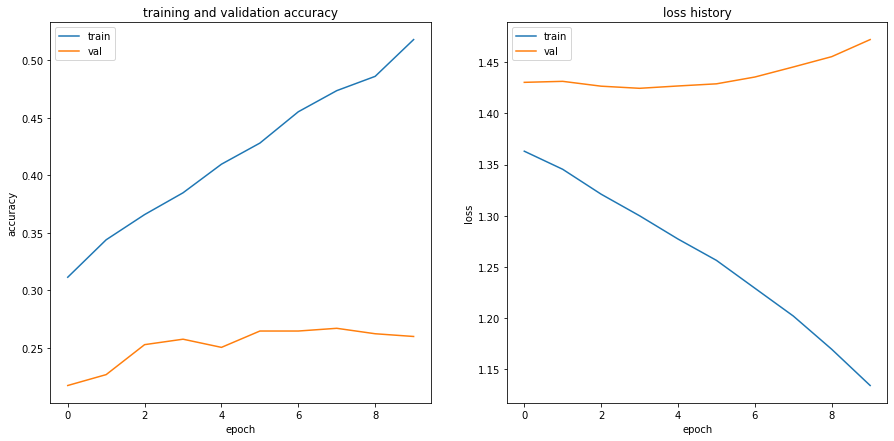

In [18]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.subplot(1, 2, 2)
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])